## Setting

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
# Import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, subprocess

In [3]:
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

# Functions for generalization

In [4]:
import copy

def callAPAoverLoop(coolFileDir, coolFileName, loopFileDir, loopFileName, minDiag, byDistance, balance, ooe):
	# minDist = minimun distance in kb to plot in APA
	# Load cool file
	cool_file = coolFileDir + '/' + coolFileName + '_KR.cool'
	clr = cooler.Cooler(f'{cool_file}')
	# Load loop file
	loop_file = loopFileDir + '/' + loopFileName + '.bedpe'
	loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
	loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
	# Load expected table
	exp_file = coolFileDir + '/' + coolFileName + '_KR_exp.tsv'
	exp_df = pd.read_csv(exp_file, delimiter='\t')

	# keep loop count
	nloops = len(loop)
	
	# Pileup
	if ooe:
		pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
							 min_diag = minDiag, by_distance = byDistance,
							 nproc = 12, 
							 clr_weight_name = balance,
							 ooe = True, expected_df = exp_df)
	else:
		 pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
							 min_diag = minDiag, by_distance = byDistance,
							 nproc = 12, 
							 clr_weight_name = balance,
							 ooe = False)       
	return pup, nloops

def get_corner_score(pup, flank = 1):
	amap = pup["data"][0]
	c = amap.shape[0] / (flank*2 + 1)
	c = int(c)
	central = np.nanmean(amap[flank*c:-flank:c, flank*c:-flank*c])
	topRight = np.nanmean(amap[:c, -c:])
	cornerScore = central/topRight
	return cornerScore, central, topRight


def drawAPA(pup, nloops, scale, colormap, vmax, vmin, fileDir, fileName):
	puptemp = copy.deepcopy(pup)
	if scale == 'log10':
		puptemp.data[0] = np.log10(puptemp.data[0])
	# Make figure
	# Enrichment score is calculated by ratio of C(obs/exp) to R (obs/exp) before doing any form of log transform
	corner = str(round(get_corner_score(pup, flank = 2)[0], 2))
	
	if vmax == False:
		fg1 = plotpup.plot(puptemp,
						   cmap = colormap,
						   score = False, 
						   scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)

		ax = fg1.ax

		ax.text(
			0.95, 0.95,                   # 95% from left, 95% from bottom
			f"corner score: {corner}",
			va="top", ha="right",
			transform=ax.transAxes,       # ← important!
			size=4
		)

		ax.text(
			0.95, 0.85,
			f"n loops: {nloops}",
			va="top", ha="right",
			transform=ax.transAxes,
			size=4
		)

	else:
		fg1 = plotpup.plot(puptemp,
				   cmap = colormap,
				   score = False, vmax = vmax, vmin = vmin,
				   scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)
		ax = fg1.ax
		ax.text(
			0.95, 0.95,                   # 95% from left, 95% from bottom
			f"corner score: {corner}",
			va="top", ha="right",
			transform=ax.transAxes,       # ← important!
			size=4
		)
		ax.text(
			0.95, 0.85,
			f"n loops: {nloops}",
			va="top", ha="right",
			transform=ax.transAxes,
			size=4
		)
	file = fileDir + '/' + fileName + '.svg'
	fg1.savefig(file, format = 'svg')
	return True


# APA plot

In [5]:
# LOADING COOL FILE
coolDir = '/Volumes/UKJIN_SSD/data/cool_norm_pooled'
figDir = '/Volumes/UKJIN_SSD/figure/loop_fithic'
loopDir = '/Volumes/UKJIN_SSD/data/loop_fithic'

os.makedirs(figDir, exist_ok=True)


INFO:coolpuppy:('chr12', 'chr12'): 20
INFO:coolpuppy:('chr10', 'chr10'): 27
INFO:coolpuppy:('chr9', 'chr9'): 11
INFO:coolpuppy:('chr7', 'chr7'): 26
INFO:coolpuppy:('chr5', 'chr5'): 19
INFO:coolpuppy:('chr8', 'chr8'): 18
INFO:coolpuppy:('chr6', 'chr6'): 14
INFO:coolpuppy:('chr4', 'chr4'): 65
INFO:coolpuppy:('chr11', 'chr11'): 71
INFO:coolpuppy:('chr3', 'chr3'): 21
INFO:coolpuppy:('chr13', 'chr13'): 122
INFO:coolpuppy:('chr2', 'chr2'): 32
INFO:coolpuppy:('chr16', 'chr16'): 14
INFO:coolpuppy:('chr19', 'chr19'): 12
INFO:coolpuppy:('chrX', 'chrX'): 13
INFO:coolpuppy:('chr1', 'chr1'): 16
INFO:coolpuppy:('chr18', 'chr18'): 11
INFO:coolpuppy:('chr15', 'chr15'): 23
INFO:coolpuppy:('chr14', 'chr14'): 16
INFO:coolpuppy:('chr17', 'chr17'): 12
INFO:coolpuppy:Total number of piled up windows: 563
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


APA_G1dTAG_pooled_fithic_10kb_fdr0.001


INFO:coolpuppy:('chr12', 'chr12'): 13
INFO:coolpuppy:('chr4', 'chr4'): 53
INFO:coolpuppy:('chr3', 'chr3'): 17
INFO:coolpuppy:('chr7', 'chr7'): 20
INFO:coolpuppy:('chr8', 'chr8'): 14
INFO:coolpuppy:('chr9', 'chr9'): 9
INFO:coolpuppy:('chr10', 'chr10'): 19
INFO:coolpuppy:('chr13', 'chr13'): 111
INFO:coolpuppy:('chrX', 'chrX'): 11
INFO:coolpuppy:('chr5', 'chr5'): 13
INFO:coolpuppy:('chr16', 'chr16'): 12
INFO:coolpuppy:('chr6', 'chr6'): 8
INFO:coolpuppy:('chr14', 'chr14'): 15
INFO:coolpuppy:('chr11', 'chr11'): 55
INFO:coolpuppy:('chr19', 'chr19'): 9
INFO:coolpuppy:('chr1', 'chr1'): 14
INFO:coolpuppy:('chr15', 'chr15'): 17
INFO:coolpuppy:('chr2', 'chr2'): 22
INFO:coolpuppy:('chr18', 'chr18'): 3
INFO:coolpuppy:('chr17', 'chr17'): 4
INFO:coolpuppy:Total number of piled up windows: 439
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


APA_G1dTAG_pooled_fithic_10kb_fdr0.0005


INFO:coolpuppy:('chr3', 'chr3'): 11
INFO:coolpuppy:('chr2', 'chr2'): 11
INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:('chr10', 'chr10'): 10
INFO:coolpuppy:('chr12', 'chr12'): 4
INFO:coolpuppy:('chr7', 'chr7'): 8
INFO:coolpuppy:('chr8', 'chr8'): 8
INFO:coolpuppy:('chr5', 'chr5'): 7
INFO:coolpuppy:('chr14', 'chr14'): 10
INFO:coolpuppy:('chr13', 'chr13'): 98
INFO:coolpuppy:('chr4', 'chr4'): 38
INFO:coolpuppy:('chr6', 'chr6'): 4
INFO:coolpuppy:('chr11', 'chr11'): 37
INFO:coolpuppy:('chr19', 'chr19'): 5
INFO:coolpuppy:('chr18', 'chr18'): 2
INFO:coolpuppy:('chrX', 'chrX'): 10
INFO:coolpuppy:('chr15', 'chr15'): 13
INFO:coolpuppy:('chr1', 'chr1'): 4
INFO:coolpuppy:('chr16', 'chr16'): 5
INFO:coolpuppy:Total number of piled up windows: 291
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


APA_G1dTAG_pooled_fithic_10kb_fdr0.0001


INFO:coolpuppy:('chr12', 'chr12'): 2500
INFO:coolpuppy:('chr7', 'chr7'): 2344
INFO:coolpuppy:('chr6', 'chr6'): 2187
INFO:coolpuppy:('chr8', 'chr8'): 2560
INFO:coolpuppy:('chr9', 'chr9'): 2444
INFO:coolpuppy:('chr10', 'chr10'): 2172
INFO:coolpuppy:('chr13', 'chr13'): 2860
INFO:coolpuppy:('chr4', 'chr4'): 2820
INFO:coolpuppy:('chr19', 'chr19'): 1146
INFO:coolpuppy:('chr3', 'chr3'): 2302
INFO:coolpuppy:('chr5', 'chr5'): 2423
INFO:coolpuppy:('chrX', 'chrX'): 571
INFO:coolpuppy:('chr16', 'chr16'): 1683
INFO:coolpuppy:('chr17', 'chr17'): 1697
INFO:coolpuppy:('chr15', 'chr15'): 1853
INFO:coolpuppy:('chr14', 'chr14'): 2109
INFO:coolpuppy:('chr18', 'chr18'): 1678
INFO:coolpuppy:('chr11', 'chr11'): 4214
INFO:coolpuppy:('chr1', 'chr1'): 3022
INFO:coolpuppy:('chr2', 'chr2'): 3653
INFO:coolpuppy:Total number of piled up windows: 46238
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


APA_G1A485_pooled_fithic_10kb_fdr0.001


python(20468) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20473) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20475) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20476) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20478) Malloc

APA_G1A485_pooled_fithic_10kb_fdr0.0005


python(20909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20912) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20914) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20917) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20919) Malloc

APA_G1A485_pooled_fithic_10kb_fdr0.0001


python(22462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22468) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22473) Malloc

APA_EpiG1DMSO_pooled_fithic_10kb_fdr0.001


python(22523) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22529) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22531) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22533) Malloc

APA_EpiG1DMSO_pooled_fithic_10kb_fdr0.0005


python(22823) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22824) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22825) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22826) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22828) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22829) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22835) Malloc

APA_EpiG1DMSO_pooled_fithic_10kb_fdr0.0001


python(22881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22884) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22886) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22891) Malloc

APA_EpiG1dTAG_pooled_fithic_10kb_fdr0.001


python(22917) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22927) Malloc

APA_EpiG1dTAG_pooled_fithic_10kb_fdr0.0005


python(23199) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23200) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23201) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23202) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23203) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23204) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23205) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23206) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23208) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23209) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(23210) Malloc

APA_EpiG1dTAG_pooled_fithic_10kb_fdr0.0001


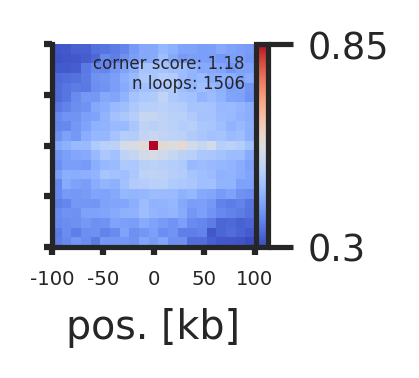

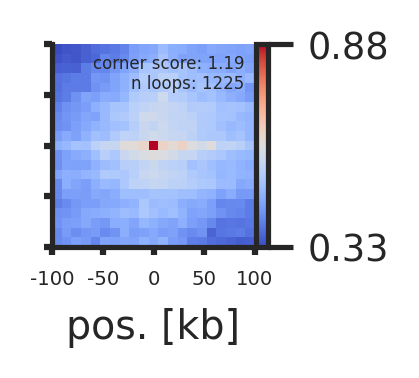

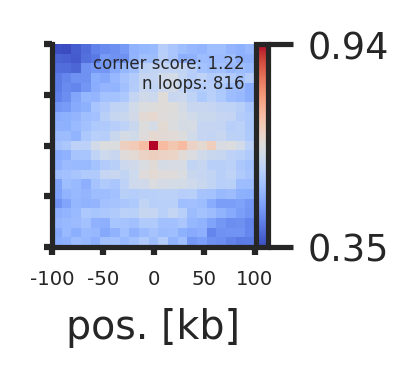

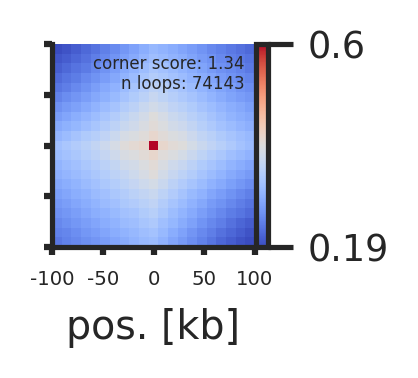

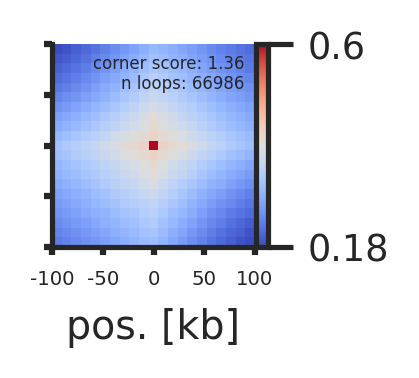

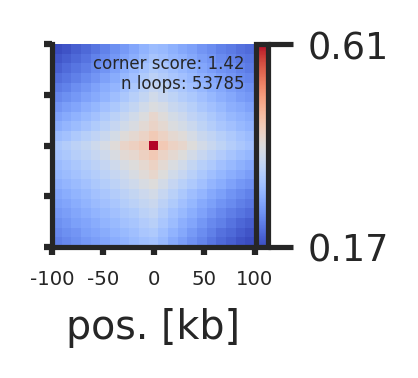

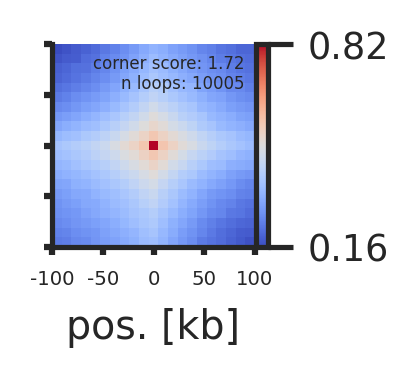

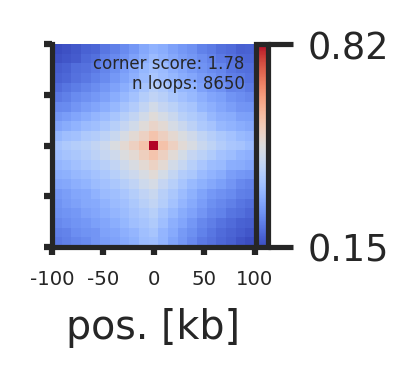

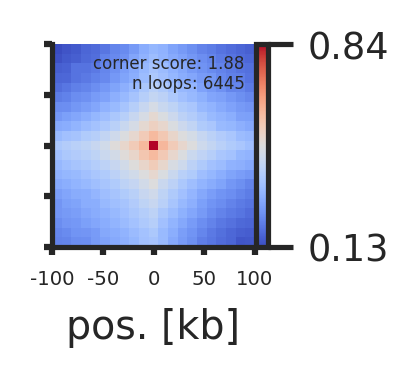

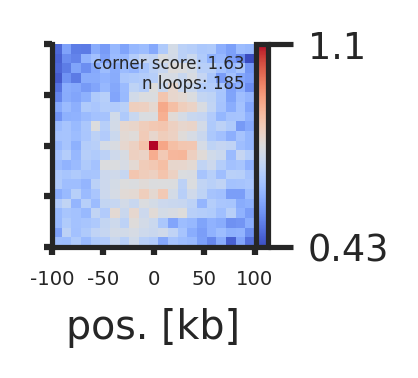

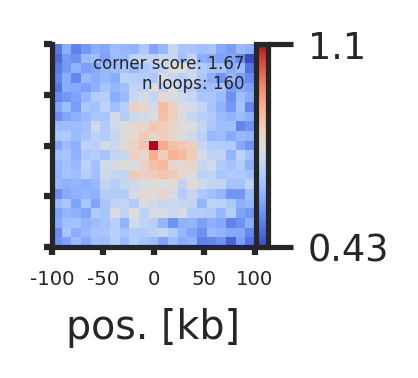

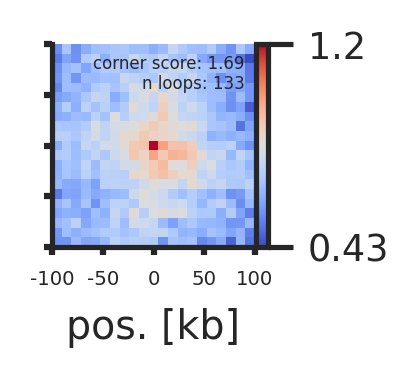

In [8]:
res='10000'

#for sample in ['G1DMSO_pooled']:
for sample in ['G1dTAG_pooled', "G1A485_pooled", "EpiG1DMSO_pooled", "EpiG1dTAG_pooled"]:
	for fdr in [0.001, 0.0005, 0.0001]:
		bedpe = f"filteredInteractions_{sample}_fdr{fdr}"
		try:
			pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
					loopDir, bedpe,
					minDiag = 2, byDistance = False,
					balance = 'weight', ooe = True)
			fileName = 'APA_' + sample + '_fithic_10kb_fdr' + str(fdr)
			print(fileName)
			drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
					fileDir = figDir, fileName = fileName)
			# drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = 1, vmin = 0,
			# fileDir = figDir, fileName = fileName + '_minmax')
		except:
			print(f"Failed to process {sample} at resolution {res} with cutoff {fdr}")
			continue
		